In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title=None):
    npimg = img.numpy()
    plt.figure()
    if title:
        plt.title(title)
    npimg = np.transpose(npimg, (1,2,0))
    cmap = None
    if npimg.shape[-1] not in [3,4]:
        npimg = npimg[:,:,0]
        cmap = 'gray'
    plt.imshow(npimg, interpolation='nearest', cmap=cmap)

In [3]:
epochs = 3

# UTKFace Data

In [4]:
batch_size = 128

In [5]:
from data import UTKFace
dataset = UTKFace(transform=transforms.Compose([
                    transforms.Grayscale(),
                    transforms.Resize((256, 256)), 
                    transforms.ToTensor()])
                 )

In [6]:
data_size = len(dataset)
train_size = int(0.9 * data_size)
test_size = data_size - train_size
data_size, train_size, test_size

(23708, 21337, 2371)

In [7]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

### Toggle cell below for sample debugging

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
a_face, age = dataset[0]

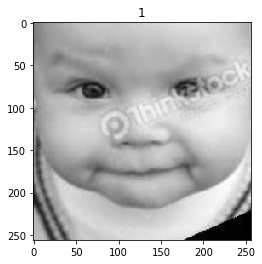

In [10]:
show(a_face, age)

# Regression Model

In [11]:
from models import Regression

In [12]:
device = torch.device("cuda")

In [13]:
model = Regression().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [14]:
import torch.nn.functional as F

def train(epoch):
    model.train()
    train_loss = 0
    for data, ages in tqdm(train_loader):
        ages = ages.float()
        ages = ages.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        pred_ages = model(data)
#         import pdb; pdb.set_trace()
        pred_ages = pred_ages * 115 + 1
        loss = F.mse_loss(pred_ages, ages)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, ages in tqdm(test_loader):  
            ages = ages.float()
            ages = ages.to(device)
            data = data.to(device)
            pred_ages = model(data)
            pred_ages = pred_ages * 115 + 1
            test_loss += F.mse_loss(pred_ages, ages).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# Load

In [15]:
weight_path = 'weights/{}_{}.pt'.format(model.__class__.__name__, dataset.__class__.__name__)
weight_path

'weights/Regression_UTKFace.pt'

# Train

In [16]:
%%time
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

  0%|          | 0/19 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 3.4512


  0%|          | 0/167 [00:00<?, ?it/s]

====> Test set loss: 3.2906


  0%|          | 0/19 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 3.1034


  0%|          | 0/167 [00:00<?, ?it/s]

====> Test set loss: 3.2847


  0%|          | 0/19 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 3.0974


100%|██████████| 19/19 [00:02<00:00,  7.90it/s]

====> Test set loss: 3.2954
CPU times: user 1min 53s, sys: 55.3 s, total: 2min 48s
Wall time: 2min 50s


# Save

In [17]:
torch.save(model.state_dict(), weight_path)

# Try it

In [18]:
import os
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path))    

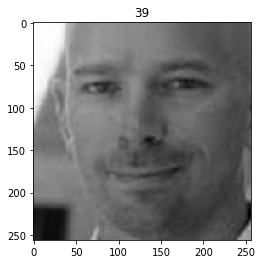

In [31]:
model.eval()

a_face, age = test_dataset[1000]
show(a_face, age)
a_face = a_face.to(device)
a_face = a_face.unsqueeze(0)

In [32]:
pred_ages = model(a_face)
pred_ages = pred_ages * 115 + 1
pred_ages

tensor([[33.3002]], device='cuda:0', grad_fn=<AddBackward0>)